
# ADR Multilabel Classification Project

In this project, I aim to classify chemical compounds based on their potential to cause multiple adverse drug reactions (ADRs). Each compound is described using its SMILES representation and associated with several binary ADR labels. The goal is to predict multiple adverse drug reactions based on chemical compound structure.


## Step 1: Dataset Loading


In [1]:
import pandas as pd
df = pd.read_csv("data_sample_full_named.csv")
df.shape

(1332, 27)


## Step 2: Exploratory Data Analysis (EDA)

We will inspect ADR distribution, compound-wise effect counts, and feature relationships.


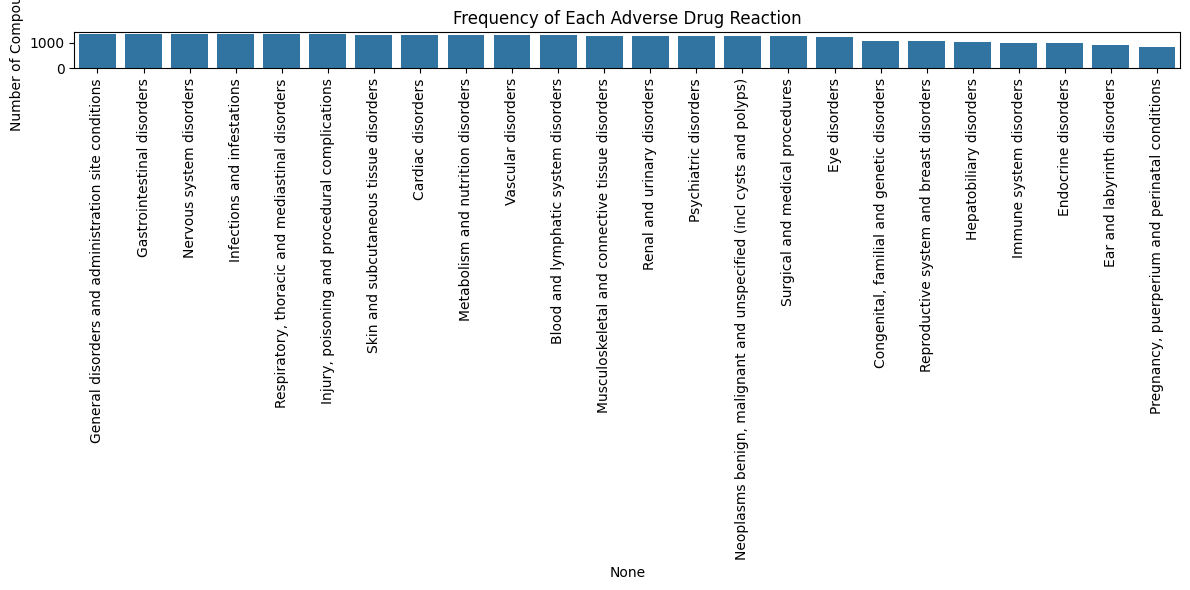

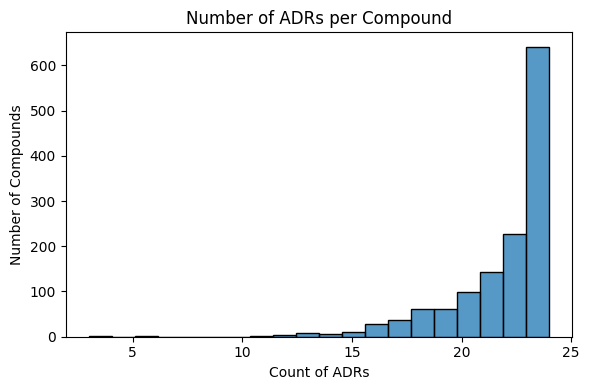

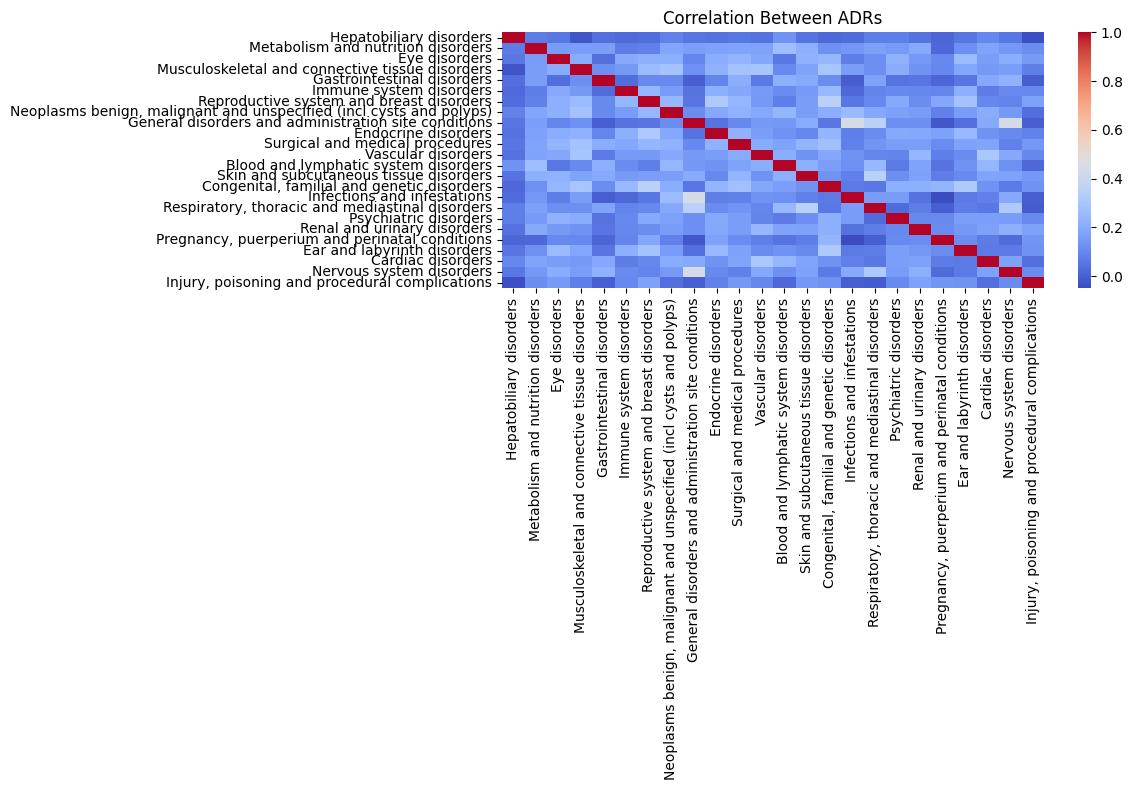

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# ADR columns (binary)
adr_columns = df.columns[1:25]

# Plot count of each ADR
adr_counts = df[adr_columns].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=adr_counts.index, y=adr_counts.values)
plt.xticks(rotation=90)
plt.title("Frequency of Each Adverse Drug Reaction")
plt.ylabel("Number of Compounds")
plt.tight_layout()
plt.show()

# Histogram: number of ADRs per compound
df["total_adr"] = df[adr_columns].sum(axis=1)
plt.figure(figsize=(6,4))
sns.histplot(df["total_adr"], bins=20, kde=False)
plt.title("Number of ADRs per Compound")
plt.xlabel("Count of ADRs")
plt.ylabel("Number of Compounds")
plt.tight_layout()
plt.show()

# Correlation between ADRs
plt.figure(figsize=(12, 8))
sns.heatmap(df[adr_columns].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Between ADRs")
plt.tight_layout()
plt.show()


## Step 3: Feature Engineering & Data Preparation

We now use `CountVectorizer` to extract features from chemical structure strings.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# Define features and labels
X_raw = df["Chemical Compound"]
Y = df.iloc[:, 1:25]

# Convert SMILES to token counts
vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2,4), max_features=1000)
X = vectorizer.fit_transform(X_raw)

X.shape, Y.shape

((1332, 1000), (1332, 24))


## Step 4: Model Comparison (Random Forest vs Logistic Regression)

Comparation of two classifiers using OneVsRest strategy:
- Random Forest
- Logistic Regression

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Random Forest
rf_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Logistic Regression
lr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

# Evaluation
print("Random Forest Classifier Report:")
print(classification_report(y_test, rf_preds))

print("Logistic Regression Report:")
print(classification_report(y_test, lr_preds))

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.89       214
           1       0.97      1.00      0.98       258
           2       0.93      0.98      0.95       250
           3       0.96      0.99      0.98       256
           4       1.00      1.00      1.00       267
           5       0.81      0.92      0.86       211
           6       0.82      0.96      0.88       215
           7       0.95      0.99      0.97       253
           8       1.00      1.00      1.00       267
           9       0.81      0.93      0.86       214
          10       0.96      1.00      0.98       256
          11       0.98      1.00      0.99       261
          12       0.96      1.00      0.98       256
          13       0.97      0.99      0.98       260
          14       0.82      0.98      0.89       219
          15       1.00      1.00      1.00       267
          16       1.00      1.00      1.00     


## Step 5: Custom Multilabel Metrics


In [9]:
# Micro and macro F1 scores
print("Random Forest Micro F1:", f1_score(y_test, rf_preds, average='micro'))
print("Random Forest Macro F1:", f1_score(y_test, rf_preds, average='macro'))

print("LogReg Micro F1:", f1_score(y_test, lr_preds, average='micro'))
print("LogReg Macro F1:", f1_score(y_test, lr_preds, average='macro'))

Random Forest Micro F1: 0.949929419579839
Random Forest Macro F1: 0.9440927752547298
LogReg Micro F1: 0.9359137594431711
LogReg Macro F1: 0.925105927145351



## Step 6: Save the Best Model

Save the Random Forest model (best performing) to disk using joblib.

In [10]:
import joblib

# Save
joblib.dump(rf_model, "adr_rf_model.joblib")
print("Random Forest model saved to 'src/models/adr_rf_model.joblib'")

Random Forest model saved to 'src/models/adr_rf_model.joblib'



## Step 7: Export Predictions

Attached predicted ADRs to each compound in the test set and export them.

In [12]:
# Restore compound names from raw data
X_test_df = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())
compound_names = df.iloc[X_test_df.index]["Compound_Name"].values

# Create DataFrame with predictions
pred_df = pd.DataFrame(rf_preds, columns=Y.columns)
pred_df.insert(0, "Compound_Name", compound_names)

# Save predictions to CSV
pred_df.to_csv("predicted_adr_by_compound.csv", index=False)
print("Exported predictions to 'src/results_notebook/predicted_adr_by_compound.csv'")

Exported predictions to 'src/results_notebook/predicted_adr_by_compound.csv'



## Step 8: Final Visualization - ADR Co-occurrence Heatmap


In [ ]:

# Show which ADRs tend to appear together in predictions
import seaborn as sns
import matplotlib.pyplot as plt

adr_corr = pd.DataFrame(rf_preds, columns=Y.columns).corr()
plt.figure(figsize=(12,8))
sns.heatmap(adr_corr, cmap='coolwarm', annot=False)
plt.title("Predicted ADR Co-occurrence")
plt.tight_layout()
plt.show()
